In [ ]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated
from pydantic import BaseModel, Field
from langchain_ollama import ChatOllama
from langchain_core.messages import SystemMessage, HumanMessage
import operator

In [ ]:
generator_llm = ChatOllama(model="mistral:7b")

evaluation_llm = ChatOllama(model='mistral:7b')

optimizer_llm = ChatOllama(model='mistral:7b')


In [ ]:
# state
class TweetState(TypedDict):
    topic : str
    tweet : str
    evaluation : Literal['approved', 'needs_improvement']
    feedback : str
    iteration : int
    max_iteration : int
    tweet_history: Annotated[list[str] , operator.add]
    feedback_history : Annotated[list[str] , operator.add]

In [ ]:
def generate_tweet(state:TweetState):
    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
You must return ONLY the tweet content, nothing else. 
DO NOT include thinking process, explanations, reasoning steps, hashtags (unless humorously part of the tweet), or any text outside the tweet itself.

TASK:
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

RULES:
- Max 280 characters.
- No question-answer style.
- Use observational humor, irony, sarcasm, or cultural references.
- Use meme logic, punchlines, or relatable takes.
- Use simple, everyday English.
- Be direct and provide only the tweet content.

OUTPUT FORMAT:
{{"tweet": "<your tweet here>"}}

IMPORTANT: Your entire reply must be valid JSON exactly in this format, with only one key "tweet".
""")
    ]
    # send to generator_llm

    response = generator_llm.invoke(messages)

    # return response
    return {'tweet':response.content,'tweet_history':[response]}

In [ ]:
class Evaluation_Schema(BaseModel):
    evaluation : Literal['needs_improvement','approved'] = Field(description='Final evaluation of the tweet')
    feedback : str = Field(..., description='Feedback for the tweet.')

In [ ]:
structured_evaluator_llm = evaluation_llm.with_structured_output(Evaluation_Schema)

In [ ]:
def evaluate_tweet(state:TweetState):
    # Evaluate the tweet based on the state
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
        Evaluate the following tweet:

        Tweet: "{state['tweet']}"

        Use the criteria below to evaluate the tweet:

        1. Originality – Is this fresh, or have you seen it a hundred times before?  
        2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
        3. Punchiness – Is it short, sharp, and scroll-stopping?  
        4. Virality Potential – Would people retweet or share it?  
        5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

        Auto-reject if:
        - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
        - It exceeds 280 characters
        - It reads like a traditional setup-punchline joke
        - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

        ### Respond ONLY in structured format:
        - evaluation: "approved" or "needs_improvement"  
        - feedback: One paragraph explaining the strengths and weaknesses 
        """)
        ]

    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback':response.feedback,'feedback_history':[response.feedback]}

In [ ]:
def optimize_tweet(state:TweetState):
    messages = [
        SystemMessage(content="You are a witty Twitter/X influencer who makes tweets go viral."),
        HumanMessage(content=f"""
You must return ONLY the optimized tweet content, nothing else. 
DO NOT include thinking process, explanations, reasoning steps, hashtags (unless humorously part of the tweet), or any text outside the tweet itself.

TASK:
Improve the tweet based on the feedback below.

FEEDBACK:
"{state['feedback']}"

TOPIC:
"{state['topic']}"

ORIGINAL TWEET:
{state['tweet']}

RULES:
- Max 280 characters.
- No question-answer style.
- Keep it punchy, funny, and viral-worthy.
- Use observational humor, irony, sarcasm, or cultural references.
- Use simple, everyday English.
- Be direct and provide only the tweet content.

OUTPUT FORMAT:
{{"tweet": "<your tweet here>"}}

IMPORTANT: Your entire reply must be valid JSON exactly in this format, with only one key "tweet".
""")
    ]
    response = optimizer_llm.invoke(messages)

    iteration = state['iteration'] + 1

    return {'tweet':response.content, 'iteration':iteration, 'tweet_history':[response]}

In [ ]:
def route_evaluation(state:TweetState):
    if state['evaluation'] == 'approved'or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else :
        return 'needs_improvement'

In [ ]:
graph = StateGraph(TweetState)

graph.add_node('generate',generate_tweet)
graph.add_node('evaluate',evaluate_tweet)
graph.add_node('optimize',optimize_tweet)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')
graph.add_conditional_edges('evaluate',route_evaluation, {'approved':END, 'needs_improvement':'optimize'})
graph.add_edge('optimize', 'evaluate')

workflow =graph.compile()



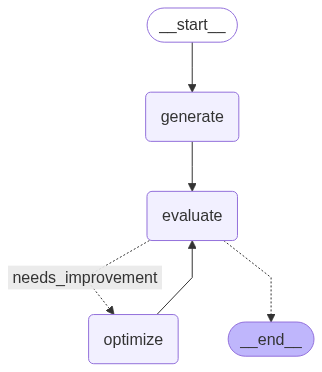

In [ ]:
workflow

In [ ]:
initial_state = {
    'topic' : "edgbeg",
    'iteration' : 1,
    'max_iteration':5
}

final_state = workflow.invoke(initial_state)

In [ ]:
final_state['tweet']

' {"tweet": "edgbeg? More like \'readgbe\' - it\'s a whole new level of enlightenment. #BackwardsWisdom"}'

In [ ]:
final_state

{'topic': 'edgbeg',
 'tweet': ' {"tweet": "edgbeg? More like \'readgbe\' - it\'s a whole new level of enlightenment. #BackwardsWisdom"}',
 'evaluation': 'approved',
 'feedback': "This tweet is approved due to its originality in reversing the phrase 'enlightenment' as 'edgbeg', which stands out from common tweets. The humor lies in the play on words and the subtle twist of the phrase, which can elicit a chuckle or smile from readers. The tweet is short, sharp, and scroll-stopping, fitting well within the 280 character limit. It also doesn't adhere to traditional setup-punchline joke format or end with generic or deflating lines. However, it might not have high virality potential, as the humor may be appreciated more among those who enjoy wordplay and puns.",
 'iteration': 1,
 'max_iteration': 5,
 'tweet_history': [AIMessage(content=' {"tweet": "edgbeg? More like \'readgbe\' - it\'s a whole new level of enlightenment. #BackwardsWisdom"}', additional_kwargs={}, response_metadata={'model':